# Transfer Learning

Most of the time you won't want to train a whole convolutional network yourself. Modern ConvNets training on huge datasets like ImageNet take weeks on multiple GPUs. Instead, most people use a pretrained network either as a fixed feature extractor, or as an initial network to fine tune. In this notebook, you'll be using [VGGNet](https://arxiv.org/pdf/1409.1556.pdf) trained on the [ImageNet dataset](http://www.image-net.org/) as a feature extractor. Below is a diagram of the VGGNet architecture.

<img src="assets/cnnarchitecture.jpg" width=700px>

VGGNet is great because it's simple and has great performance, coming in second in the ImageNet competition. The idea here is that we keep all the convolutional layers, but replace the final fully connected layers with our own classifier. This way we can use VGGNet as a feature extractor for our images then easily train a simple classifier on top of that. What we'll do is take the first fully connected layer with 4096 units, including thresholding with ReLUs. We can use those values as a code for each image, then build a classifier on top of those codes.

You can read more about transfer learning from [the CS231n course notes](http://cs231n.github.io/transfer-learning/#tf).

## Pretrained VGGNet

We'll be using a pretrained network from https://github.com/machrisaa/tensorflow-vgg. Make sure to clone this repository to the directory you're working from. You'll also want to rename it so it has an underscore instead of a dash.

```
git clone https://github.com/machrisaa/tensorflow-vgg.git tensorflow_vgg
```

This is a really nice implementation of VGGNet, quite easy to work with. The network has already been trained and the parameters are available from this link. **You'll need to clone the repo into the folder containing this notebook.** Then download the parameter file using the next cell.

确认已经下载OK

代码改造自 udacity迁移学习，这里只包含一个ipython文件，其他的使用uda的即可

In [1]:
import os

import numpy as np
import tensorflow as tf

from tensorflow_vgg import vgg16
from tensorflow_vgg import utils

from urllib.request import urlretrieve
from os.path import isfile, isdir
from tqdm import tqdm

vgg_dir = 'tensorflow_vgg/'
# Make sure vgg exists
if not isdir(vgg_dir):
    raise Exception("VGG directory doesn't exist!")

class DLProgress(tqdm):
    last_block = 0

    def hook(self, block_num=1, block_size=1, total_size=None):
        self.total = total_size
        self.update((block_num - self.last_block) * block_size)
        self.last_block = block_num

if not isfile(vgg_dir + "vgg16.npy"):
    with DLProgress(unit='B', unit_scale=True, miniters=1, desc='VGG16 Parameters') as pbar:
        urlretrieve(
            'https://s3.amazonaws.com/content.udacity-data.com/nd101/vgg16.npy',
            vgg_dir + 'vgg16.npy',

            pbar.hook)
else:
    print("Parameter file already exists!")

# tensorflow gpu error
def fix_gpu_error():
    if 'session' in locals() and session is not None:
        print('Close interactive session')
        session.close()
    gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.95)
    sess = tf.Session(config=tf.ConfigProto(gpu_options=gpu_options))

Parameter file already exists!


读取类别

In [40]:
def read_pic_path(data_dir):
    contents = os.listdir(data_dir)
    classes = [each for each in contents if os.path.isdir(data_dir + each)]
    return classes

train_dir = 'pigImages/train/'
test_dir = 'pigImages/test/'
valid_dir = 'pigImages/valid/'

# 将目录名称变换为名称的list
train_classes = read_pic_path(train_dir)
print(train_classes)

test_classes = read_pic_path(test_dir)
print(test_classes)

valid_classes = read_pic_path(valid_dir)
print(valid_classes)

['01.pig', '02.pig', '03.pig', '04.pig', '05.pig', '06.pig', '07.pig', '08.pig', '09.pig', '10.pig', '11.pig', '12.pig', '13.pig', '14.pig', '15.pig', '16.pig', '17.pig', '18.pig', '19.pig', '20.pig', '21.pig', '22.pig', '23.pig', '24.pig', '25.pig', '26.pig', '27.pig', '28.pig', '29.pig', '30.pig']
['01.pig', '02.pig', '03.pig', '04.pig', '05.pig', '06.pig', '07.pig', '08.pig', '09.pig', '10.pig', '11.pig', '12.pig', '13.pig', '14.pig', '15.pig', '16.pig', '17.pig', '18.pig', '19.pig', '20.pig', '21.pig', '22.pig', '23.pig', '24.pig', '25.pig', '26.pig', '27.pig', '28.pig', '29.pig', '30.pig']
['01.pig', '02.pig', '03.pig', '04.pig', '05.pig', '06.pig', '07.pig', '08.pig', '09.pig', '10.pig', '11.pig', '12.pig', '13.pig', '14.pig', '15.pig', '16.pig', '17.pig', '18.pig', '19.pig', '20.pig', '21.pig', '22.pig', '23.pig', '24.pig', '25.pig', '26.pig', '27.pig', '28.pig', '29.pig', '30.pig']


预处理图像，分batch

构建迁移模型运行方式

In [41]:
# Set the batch size higher if you can fit in in your GPU memory
def run_transfer_model(data_dir, classes, batch_size = 2):
    codes_list = []
    labels = []
    batch = []
    codes = None
    
    fix_gpu_error()
    
    tf.reset_default_graph()

    with tf.Session() as sess:
        # TODO: Build the vgg network here
        vgg = vgg16.Vgg16()
        input_ = tf.placeholder(tf.float32, [None, 224, 224, 3])
        with tf.name_scope("content_vgg"):
            vgg.build(input_)

        for each in classes:
            print("Starting {} images".format(each))
            class_path = data_dir + each
            # 列出所有的文件名称
            files = os.listdir(class_path)
            for ii, file in enumerate(files, 1):
                # Add images to the current batch
                # utils.load_image crops the input images for us, from the center
            
                # 每次添加一张图片
                img = utils.load_image(os.path.join(class_path, file))
                # 每次处理一张图片
                batch.append(img.reshape((1, 224, 224, 3)))
                # 每次添加一个labels
                labels.append(each)
                
                print("###")
            
                # Running the batch through the network to get the codes
                if ii % batch_size == 0 or ii == len(files):
                
                    # Image batch to pass to VGG network
                    images = np.concatenate(batch)
                    print(len(batch))
                    print(len(images))
                    print(images.shape)
                    # TODO: Get the values from the relu6 layer of the VGG network
                    feed_dict = {input_: images}
                    codes_batch = sess.run(vgg.relu6, feed_dict=feed_dict)
                
                    # Here I'm building an array of the codes
                    if codes is None:
                        codes = codes_batch
                    else:
                        codes = np.concatenate((codes, codes_batch))
                
                    print(len(codes))
                
                    # Reset to start building the next batch
                    batch = []
                    print('{} images processed'.format(ii))
    return codes, labels

运行构建好的迁移模型，获得 cnn code

In [42]:
train_codes, train_labels = run_transfer_model(train_dir, train_classes)
test_codes, test_labels = run_transfer_model(test_dir, train_classes)
valid_codes, valid_labels = run_transfer_model(valid_dir, train_classes)

E:\PROJECT\Code\Sample-tranferlearning-vgg\tensorflow_vgg\vgg16.npy
npy file loaded
build model started
build model finished: 0s
Starting 01.pig images
###
###
2
2
(2, 224, 224, 3)
2
2 images processed
###
###
2
2
(2, 224, 224, 3)
4
4 images processed
###
###
2
2
(2, 224, 224, 3)
6
6 images processed
###
###
2
2
(2, 224, 224, 3)
8
8 images processed
###
###
2
2
(2, 224, 224, 3)
10
10 images processed
###
###
2
2
(2, 224, 224, 3)
12
12 images processed
###
###
2
2
(2, 224, 224, 3)
14
14 images processed
###
###
2
2
(2, 224, 224, 3)
16
16 images processed
###
###
2
2
(2, 224, 224, 3)
18
18 images processed
###
###
2
2
(2, 224, 224, 3)
20
20 images processed
###
###
2
2
(2, 224, 224, 3)
22
22 images processed
###
###
2
2
(2, 224, 224, 3)
24
24 images processed
###
###
2
2
(2, 224, 224, 3)
26
26 images processed
###
###
2
2
(2, 224, 224, 3)
28
28 images processed
###
###
2
2
(2, 224, 224, 3)
30
30 images processed
###
###
2
2
(2, 224, 224, 3)
32
32 images processed
###
###
2
2
(2, 224, 224

301
50 images processed
###
###
2
2
(2, 224, 224, 3)
303
52 images processed
###
###
2
2
(2, 224, 224, 3)
305
54 images processed
###
###
2
2
(2, 224, 224, 3)
307
56 images processed
###
1
1
(1, 224, 224, 3)
308
57 images processed
Starting 06.pig images
###
###
2
2
(2, 224, 224, 3)
310
2 images processed
###
###
2
2
(2, 224, 224, 3)
312
4 images processed
###
###
2
2
(2, 224, 224, 3)
314
6 images processed
###
###
2
2
(2, 224, 224, 3)
316
8 images processed
###
###
2
2
(2, 224, 224, 3)
318
10 images processed
###
###
2
2
(2, 224, 224, 3)
320
12 images processed
###
###
2
2
(2, 224, 224, 3)
322
14 images processed
###
###
2
2
(2, 224, 224, 3)
324
16 images processed
###
###
2
2
(2, 224, 224, 3)
326
18 images processed
###
###
2
2
(2, 224, 224, 3)
328
20 images processed
###
###
2
2
(2, 224, 224, 3)
330
22 images processed
###
###
2
2
(2, 224, 224, 3)
332
24 images processed
###
###
2
2
(2, 224, 224, 3)
334
26 images processed
###
###
2
2
(2, 224, 224, 3)
336
28 images processed
###
###

2
(2, 224, 224, 3)
604
48 images processed
###
###
2
2
(2, 224, 224, 3)
606
50 images processed
###
###
2
2
(2, 224, 224, 3)
608
52 images processed
###
###
2
2
(2, 224, 224, 3)
610
54 images processed
###
###
2
2
(2, 224, 224, 3)
612
56 images processed
###
###
2
2
(2, 224, 224, 3)
614
58 images processed
###
###
2
2
(2, 224, 224, 3)
616
60 images processed
###
###
2
2
(2, 224, 224, 3)
618
62 images processed
###
###
2
2
(2, 224, 224, 3)
620
64 images processed
###
###
2
2
(2, 224, 224, 3)
622
66 images processed
###
###
2
2
(2, 224, 224, 3)
624
68 images processed
###
###
2
2
(2, 224, 224, 3)
626
70 images processed
###
###
2
2
(2, 224, 224, 3)
628
72 images processed
###
###
2
2
(2, 224, 224, 3)
630
74 images processed
###
###
2
2
(2, 224, 224, 3)
632
76 images processed
###
###
2
2
(2, 224, 224, 3)
634
78 images processed
###
###
2
2
(2, 224, 224, 3)
636
80 images processed
###
1
1
(1, 224, 224, 3)
637
81 images processed
Starting 12.pig images
###
###
2
2
(2, 224, 224, 3)
639
2 im

2
(2, 224, 224, 3)
907
22 images processed
###
###
2
2
(2, 224, 224, 3)
909
24 images processed
###
###
2
2
(2, 224, 224, 3)
911
26 images processed
###
###
2
2
(2, 224, 224, 3)
913
28 images processed
###
###
2
2
(2, 224, 224, 3)
915
30 images processed
###
###
2
2
(2, 224, 224, 3)
917
32 images processed
###
###
2
2
(2, 224, 224, 3)
919
34 images processed
###
###
2
2
(2, 224, 224, 3)
921
36 images processed
###
###
2
2
(2, 224, 224, 3)
923
38 images processed
###
###
2
2
(2, 224, 224, 3)
925
40 images processed
###
###
2
2
(2, 224, 224, 3)
927
42 images processed
###
###
2
2
(2, 224, 224, 3)
929
44 images processed
###
###
2
2
(2, 224, 224, 3)
931
46 images processed
###
###
2
2
(2, 224, 224, 3)
933
48 images processed
Starting 17.pig images
###
###
2
2
(2, 224, 224, 3)
935
2 images processed
###
###
2
2
(2, 224, 224, 3)
937
4 images processed
###
###
2
2
(2, 224, 224, 3)
939
6 images processed
###
###
2
2
(2, 224, 224, 3)
941
8 images processed
###
###
2
2
(2, 224, 224, 3)
943
10 i

###
2
2
(2, 224, 224, 3)
1208
42 images processed
###
###
2
2
(2, 224, 224, 3)
1210
44 images processed
###
###
2
2
(2, 224, 224, 3)
1212
46 images processed
###
###
2
2
(2, 224, 224, 3)
1214
48 images processed
###
1
1
(1, 224, 224, 3)
1215
49 images processed
Starting 22.pig images
###
###
2
2
(2, 224, 224, 3)
1217
2 images processed
###
###
2
2
(2, 224, 224, 3)
1219
4 images processed
###
###
2
2
(2, 224, 224, 3)
1221
6 images processed
###
###
2
2
(2, 224, 224, 3)
1223
8 images processed
###
###
2
2
(2, 224, 224, 3)
1225
10 images processed
###
###
2
2
(2, 224, 224, 3)
1227
12 images processed
###
###
2
2
(2, 224, 224, 3)
1229
14 images processed
###
###
2
2
(2, 224, 224, 3)
1231
16 images processed
###
###
2
2
(2, 224, 224, 3)
1233
18 images processed
###
###
2
2
(2, 224, 224, 3)
1235
20 images processed
###
###
2
2
(2, 224, 224, 3)
1237
22 images processed
###
###
2
2
(2, 224, 224, 3)
1239
24 images processed
###
###
2
2
(2, 224, 224, 3)
1241
26 images processed
###
###
2
2
(2, 2

8 images processed
###
###
2
2
(2, 224, 224, 3)
1504
10 images processed
###
###
2
2
(2, 224, 224, 3)
1506
12 images processed
###
###
2
2
(2, 224, 224, 3)
1508
14 images processed
###
###
2
2
(2, 224, 224, 3)
1510
16 images processed
###
###
2
2
(2, 224, 224, 3)
1512
18 images processed
###
###
2
2
(2, 224, 224, 3)
1514
20 images processed
###
###
2
2
(2, 224, 224, 3)
1516
22 images processed
###
###
2
2
(2, 224, 224, 3)
1518
24 images processed
###
###
2
2
(2, 224, 224, 3)
1520
26 images processed
###
###
2
2
(2, 224, 224, 3)
1522
28 images processed
###
###
2
2
(2, 224, 224, 3)
1524
30 images processed
###
###
2
2
(2, 224, 224, 3)
1526
32 images processed
###
###
2
2
(2, 224, 224, 3)
1528
34 images processed
###
###
2
2
(2, 224, 224, 3)
1530
36 images processed
###
###
2
2
(2, 224, 224, 3)
1532
38 images processed
###
###
2
2
(2, 224, 224, 3)
1534
40 images processed
###
###
2
2
(2, 224, 224, 3)
1536
42 images processed
###
###
2
2
(2, 224, 224, 3)
1538
44 images processed
###
###
2

1
1
(1, 224, 224, 3)
90
5 images processed
Starting 15.pig images
###
###
2
2
(2, 224, 224, 3)
92
2 images processed
###
###
2
2
(2, 224, 224, 3)
94
4 images processed
###
1
1
(1, 224, 224, 3)
95
5 images processed
Starting 16.pig images
###
###
2
2
(2, 224, 224, 3)
97
2 images processed
###
###
2
2
(2, 224, 224, 3)
99
4 images processed
###
1
1
(1, 224, 224, 3)
100
5 images processed
Starting 17.pig images
###
###
2
2
(2, 224, 224, 3)
102
2 images processed
###
###
2
2
(2, 224, 224, 3)
104
4 images processed
###
###
2
2
(2, 224, 224, 3)
106
6 images processed
Starting 18.pig images
###
###
2
2
(2, 224, 224, 3)
108
2 images processed
###
###
2
2
(2, 224, 224, 3)
110
4 images processed
###
1
1
(1, 224, 224, 3)
111
5 images processed
Starting 19.pig images
###
###
2
2
(2, 224, 224, 3)
113
2 images processed
###
###
2
2
(2, 224, 224, 3)
115
4 images processed
###
###
2
2
(2, 224, 224, 3)
117
6 images processed
Starting 20.pig images
###
###
2
2
(2, 224, 224, 3)
119
2 images processed
###


Starting 28.pig images
###
###
2
2
(2, 224, 224, 3)
168
2 images processed
###
###
2
2
(2, 224, 224, 3)
170
4 images processed
###
###
2
2
(2, 224, 224, 3)
172
6 images processed
Starting 29.pig images
###
###
2
2
(2, 224, 224, 3)
174
2 images processed
###
###
2
2
(2, 224, 224, 3)
176
4 images processed
###
###
2
2
(2, 224, 224, 3)
178
6 images processed
Starting 30.pig images
###
###
2
2
(2, 224, 224, 3)
180
2 images processed
###
###
2
2
(2, 224, 224, 3)
182
4 images processed
###
###
2
2
(2, 224, 224, 3)
184
6 images processed


将cnn code 保存到文件中

In [44]:
import csv

def save2file(codes_file, codes_name, labels_file, labels_name):
    # write codes to file
    with open(codes_name, 'w') as f:
        codes_file.tofile(f)

    # write labels to file    
    with open(labels_name, 'w') as f:
        writer = csv.writer(f, delimiter='\n')
        writer.writerow(labels_file)

save2file(train_codes, 'train_codes', train_labels, 'train_labels')
save2file(test_codes, 'test_codes', test_labels, 'test_labels')
save2file(valid_codes, 'valid_codes', valid_labels, 'valid_labels')


## 检查点

已经保存好的模型，可以从这里开始运行

In [16]:
import os

import numpy as np
import tensorflow as tf

from tensorflow_vgg import vgg16
from tensorflow_vgg import utils

from urllib.request import urlretrieve
from os.path import isfile, isdir
from tqdm import tqdm

# tensorflow gpu error
def fix_gpu_error():
    if 'session' in locals() and session is not None:
        print('Close interactive session')
        session.close()
    gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.95)
    sess = tf.Session(config=tf.ConfigProto(gpu_options=gpu_options))

读取cnn code

In [17]:
# read codes and labels from file
import csv

def read_from_file(codes_name, labels_name):
    with open(labels_name) as f:
        reader = csv.reader(f, delimiter='\n')
        labels = np.array([each for each in reader if len(each) > 0]).squeeze()
    with open(codes_name) as f:
        codes = np.fromfile(f, dtype=np.float32)
        codes = codes.reshape((len(labels), -1))
    return codes, labels

train_codes, train_labels = read_from_file('train_codes', 'train_labels')
test_codes, test_labels = read_from_file('test_codes', 'test_labels')
valid_codes, valid_labels = read_from_file('valid_codes', 'valid_labels')

独热编码

In [18]:
from sklearn.preprocessing import LabelBinarizer

def one_hot_encode(labels):
    lb = LabelBinarizer()
    lb.fit(labels)
    return lb.transform(labels)

train_labels_vecs = one_hot_encode(train_labels)
test_labels_vecs = one_hot_encode(test_labels)
valid_labels_vecs = one_hot_encode(valid_labels)
print(train_labels_vecs[0])

lb = LabelBinarizer()
lb.fit(train_labels)
lb.transform(train_labels)

[1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


array([[1, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 1],
       [0, 0, 0, ..., 0, 0, 1],
       [0, 0, 0, ..., 0, 0, 1]])

准备训练，测试，验证的数据

In [19]:
train_x, train_y = train_codes, train_labels_vecs
test_x, test_y = test_codes, test_labels_vecs
val_x, val_y = valid_codes, valid_labels_vecs

随机化数据

暂未实现

### Classifier layers

Once you have the convolutional codes, you just need to build a classfier from some fully connected layers. You use the codes as the inputs and the image labels as targets. Otherwise the classifier is a typical neural network.

> **Exercise:** With the codes and labels loaded, build the classifier. Consider the codes as your inputs, each of them are 4096D vectors. You'll want to use a hidden layer and an output layer as your classifier. Remember that the output layer needs to have one unit for each class and a softmax activation function. Use the cross entropy to calculate the cost.

In [20]:
inputs_ = tf.placeholder(tf.float32, shape=[None, train_x.shape[1]])
labels_ = tf.placeholder(tf.int64, shape=[None, train_y.shape[1]])

# default use ReLU activation func
fc = tf.contrib.layers.fully_connected(inputs_, 1024)
tf.nn.dropout(fc, 0.5)
fc = tf.contrib.layers.fully_connected(fc, 256)
tf.nn.dropout(fc, 0.5)

# output, none activation func
logits = tf.contrib.layers.fully_connected(fc, train_y.shape[1], activation_fn=None)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(labels=labels_, logits=logits)
cost = tf.reduce_mean(cross_entropy)

optimizer = tf.train.AdamOptimizer().minimize(cost)

# Operations for validation/test accuracy
predicted = tf.nn.softmax(logits)
correct_pred = tf.equal(tf.argmax(predicted, 1), tf.argmax(labels_, 1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

### Batches!

Here is just a simple way to do batches. I've written it so that it includes all the data. Sometimes you'll throw out some data at the end to make sure you have full batches. Here I just extend the last batch to include the remaining data.

In [21]:
def get_batches(x, y, n_batches=10):
    """ Return a generator that yields batches from arrays x and y. """
    batch_size = len(x)//n_batches
    
    for ii in range(0, n_batches*batch_size, batch_size):
        # If we're not on the last batch, grab data with size batch_size
        if ii != (n_batches-1)*batch_size:
            X, Y = x[ii: ii+batch_size], y[ii: ii+batch_size] 
        # On the last batch, grab the rest of the data
        else:
            X, Y = x[ii:], y[ii:]
        # I love generators
        yield X, Y

### Training

Here, we'll train the network.

> **Exercise:** So far we've been providing the training code for you. Here, I'm going to give you a bit more of a challenge and have you write the code to train the network. Of course, you'll be able to see my solution if you need help. Use the `get_batches` function I wrote before to get your batches like `for x, y in get_batches(train_x, train_y)`. Or write your own!

In [22]:
epochs = 100
batches = 20
iteration = 0

saver = tf.train.Saver()


with tf.Session() as sess:
    fix_gpu_error()
    sess.run(tf.global_variables_initializer())
    
    for e in range(epochs):
        for x, y in get_batches(train_x, train_y, batches):
            feed = {inputs_: x,
                    labels_: y}
            loss, _ = sess.run([cost, optimizer], feed_dict=feed)
            print("Epoch: {}/{}".format(e+1, epochs),
                  "Iteration: {}".format(iteration),
                  "Training loss: {:.5f}".format(loss))
            iteration += 1
            
            if iteration % 5 == 0:
                feed = {inputs_: val_x,
                        labels_: val_y}
                val_acc = sess.run(accuracy, feed_dict=feed)
                loss = sess.run(cost, feed_dict=feed)
                print("Epoch: {}/{}".format(e, epochs),
                      "Iteration: {}".format(iteration),
                      "Validation Acc: {:.4f}".format(val_acc),
                      "Validation Loss: {:.4f}".format(loss))
    saver.save(sess, "checkpoints/pig.ckpt")

Epoch: 1/100 Iteration: 0 Training loss: 7.99926
Epoch: 1/100 Iteration: 1 Training loss: 55.97701
Epoch: 1/100 Iteration: 2 Training loss: 45.13152
Epoch: 1/100 Iteration: 3 Training loss: 46.55102
Epoch: 1/100 Iteration: 4 Training loss: 41.11792
Epoch: 0/100 Iteration: 5 Validation Acc: 0.0652 Validation Loss: 26.6137
Epoch: 1/100 Iteration: 5 Training loss: 17.60191
Epoch: 1/100 Iteration: 6 Training loss: 34.40160
Epoch: 1/100 Iteration: 7 Training loss: 25.41107
Epoch: 1/100 Iteration: 8 Training loss: 18.35270
Epoch: 1/100 Iteration: 9 Training loss: 21.73274
Epoch: 0/100 Iteration: 10 Validation Acc: 0.0326 Validation Loss: 13.3499
Epoch: 1/100 Iteration: 10 Training loss: 15.31987
Epoch: 1/100 Iteration: 11 Training loss: 12.03728
Epoch: 1/100 Iteration: 12 Training loss: 13.34851
Epoch: 1/100 Iteration: 13 Training loss: 7.87446
Epoch: 1/100 Iteration: 14 Training loss: 8.48979
Epoch: 0/100 Iteration: 15 Validation Acc: 0.0707 Validation Loss: 10.3951
Epoch: 1/100 Iteration: 

Epoch: 7/100 Iteration: 126 Training loss: 3.39485
Epoch: 7/100 Iteration: 127 Training loss: 3.39011
Epoch: 7/100 Iteration: 128 Training loss: 3.12285
Epoch: 7/100 Iteration: 129 Training loss: 3.31282
Epoch: 6/100 Iteration: 130 Validation Acc: 0.0326 Validation Loss: 3.3651
Epoch: 7/100 Iteration: 130 Training loss: 3.43295
Epoch: 7/100 Iteration: 131 Training loss: 3.37478
Epoch: 7/100 Iteration: 132 Training loss: 3.27811
Epoch: 7/100 Iteration: 133 Training loss: 3.34951
Epoch: 7/100 Iteration: 134 Training loss: 3.55386
Epoch: 6/100 Iteration: 135 Validation Acc: 0.0707 Validation Loss: 3.4162
Epoch: 7/100 Iteration: 135 Training loss: 3.59630
Epoch: 7/100 Iteration: 136 Training loss: 3.50117
Epoch: 7/100 Iteration: 137 Training loss: 3.39207
Epoch: 7/100 Iteration: 138 Training loss: 3.23839
Epoch: 7/100 Iteration: 139 Training loss: 3.36236
Epoch: 6/100 Iteration: 140 Validation Acc: 0.0380 Validation Loss: 3.3570
Epoch: 8/100 Iteration: 140 Training loss: 2.62601
Epoch: 8/1

Epoch: 13/100 Iteration: 249 Training loss: 2.99791
Epoch: 12/100 Iteration: 250 Validation Acc: 0.0707 Validation Loss: 3.3437
Epoch: 13/100 Iteration: 250 Training loss: 3.24464
Epoch: 13/100 Iteration: 251 Training loss: 3.00543
Epoch: 13/100 Iteration: 252 Training loss: 3.41081
Epoch: 13/100 Iteration: 253 Training loss: 3.43261
Epoch: 13/100 Iteration: 254 Training loss: 3.22317
Epoch: 12/100 Iteration: 255 Validation Acc: 0.0652 Validation Loss: 3.3330
Epoch: 13/100 Iteration: 255 Training loss: 3.41045
Epoch: 13/100 Iteration: 256 Training loss: 3.46451
Epoch: 13/100 Iteration: 257 Training loss: 3.21232
Epoch: 13/100 Iteration: 258 Training loss: 2.59616
Epoch: 13/100 Iteration: 259 Training loss: 3.14147
Epoch: 12/100 Iteration: 260 Validation Acc: 0.0707 Validation Loss: 3.3192
Epoch: 14/100 Iteration: 260 Training loss: 2.46250
Epoch: 14/100 Iteration: 261 Training loss: 3.10812
Epoch: 14/100 Iteration: 262 Training loss: 3.34655
Epoch: 14/100 Iteration: 263 Training loss: 

Epoch: 19/100 Iteration: 370 Training loss: 2.66401
Epoch: 19/100 Iteration: 371 Training loss: 2.36675
Epoch: 19/100 Iteration: 372 Training loss: 3.22006
Epoch: 19/100 Iteration: 373 Training loss: 3.37144
Epoch: 19/100 Iteration: 374 Training loss: 2.70852
Epoch: 18/100 Iteration: 375 Validation Acc: 0.0924 Validation Loss: 3.1923
Epoch: 19/100 Iteration: 375 Training loss: 3.42274
Epoch: 19/100 Iteration: 376 Training loss: 3.36798
Epoch: 19/100 Iteration: 377 Training loss: 2.50239
Epoch: 19/100 Iteration: 378 Training loss: 1.34485
Epoch: 19/100 Iteration: 379 Training loss: 2.93556
Epoch: 18/100 Iteration: 380 Validation Acc: 0.1250 Validation Loss: 3.1621
Epoch: 20/100 Iteration: 380 Training loss: 1.68376
Epoch: 20/100 Iteration: 381 Training loss: 2.73562
Epoch: 20/100 Iteration: 382 Training loss: 3.45582
Epoch: 20/100 Iteration: 383 Training loss: 3.37402
Epoch: 20/100 Iteration: 384 Training loss: 4.68810
Epoch: 19/100 Iteration: 385 Validation Acc: 0.1522 Validation Loss:

Epoch: 25/100 Iteration: 492 Training loss: 2.58264
Epoch: 25/100 Iteration: 493 Training loss: 2.12833
Epoch: 25/100 Iteration: 494 Training loss: 0.79263
Epoch: 24/100 Iteration: 495 Validation Acc: 0.2228 Validation Loss: 2.9193
Epoch: 25/100 Iteration: 495 Training loss: 2.38140
Epoch: 25/100 Iteration: 496 Training loss: 2.44134
Epoch: 25/100 Iteration: 497 Training loss: 2.16620
Epoch: 25/100 Iteration: 498 Training loss: 1.15126
Epoch: 25/100 Iteration: 499 Training loss: 2.36540
Epoch: 24/100 Iteration: 500 Validation Acc: 0.1576 Validation Loss: 3.0891
Epoch: 26/100 Iteration: 500 Training loss: 0.83792
Epoch: 26/100 Iteration: 501 Training loss: 2.66824
Epoch: 26/100 Iteration: 502 Training loss: 3.10289
Epoch: 26/100 Iteration: 503 Training loss: 2.10807
Epoch: 26/100 Iteration: 504 Training loss: 2.97538
Epoch: 25/100 Iteration: 505 Validation Acc: 0.1739 Validation Loss: 3.0359
Epoch: 26/100 Iteration: 505 Training loss: 2.37529
Epoch: 26/100 Iteration: 506 Training loss: 

Epoch: 31/100 Iteration: 614 Training loss: 0.96427
Epoch: 30/100 Iteration: 615 Validation Acc: 0.3587 Validation Loss: 2.6709
Epoch: 31/100 Iteration: 615 Training loss: 2.19701
Epoch: 31/100 Iteration: 616 Training loss: 1.18336
Epoch: 31/100 Iteration: 617 Training loss: 1.87967
Epoch: 31/100 Iteration: 618 Training loss: 0.81590
Epoch: 31/100 Iteration: 619 Training loss: 1.76157
Epoch: 30/100 Iteration: 620 Validation Acc: 0.3370 Validation Loss: 2.5842
Epoch: 32/100 Iteration: 620 Training loss: 0.80051
Epoch: 32/100 Iteration: 621 Training loss: 1.54868
Epoch: 32/100 Iteration: 622 Training loss: 2.15283
Epoch: 32/100 Iteration: 623 Training loss: 2.22088
Epoch: 32/100 Iteration: 624 Training loss: 1.69890
Epoch: 31/100 Iteration: 625 Validation Acc: 0.3424 Validation Loss: 2.4777
Epoch: 32/100 Iteration: 625 Training loss: 2.28158
Epoch: 32/100 Iteration: 626 Training loss: 1.04296
Epoch: 32/100 Iteration: 627 Training loss: 2.02510
Epoch: 32/100 Iteration: 628 Training loss: 

Epoch: 37/100 Iteration: 735 Training loss: 0.68563
Epoch: 37/100 Iteration: 736 Training loss: 0.76747
Epoch: 37/100 Iteration: 737 Training loss: 0.48279
Epoch: 37/100 Iteration: 738 Training loss: 0.56730
Epoch: 37/100 Iteration: 739 Training loss: 0.49133
Epoch: 36/100 Iteration: 740 Validation Acc: 0.5109 Validation Loss: 2.3482
Epoch: 38/100 Iteration: 740 Training loss: 0.68360
Epoch: 38/100 Iteration: 741 Training loss: 0.71488
Epoch: 38/100 Iteration: 742 Training loss: 2.53424
Epoch: 38/100 Iteration: 743 Training loss: 2.53109
Epoch: 38/100 Iteration: 744 Training loss: 1.05442
Epoch: 37/100 Iteration: 745 Validation Acc: 0.4837 Validation Loss: 2.1604
Epoch: 38/100 Iteration: 745 Training loss: 0.99898
Epoch: 38/100 Iteration: 746 Training loss: 0.24944
Epoch: 38/100 Iteration: 747 Training loss: 1.18756
Epoch: 38/100 Iteration: 748 Training loss: 0.53118
Epoch: 38/100 Iteration: 749 Training loss: 0.85953
Epoch: 37/100 Iteration: 750 Validation Acc: 0.5217 Validation Loss:

Epoch: 43/100 Iteration: 857 Training loss: 1.10821
Epoch: 43/100 Iteration: 858 Training loss: 0.19015
Epoch: 43/100 Iteration: 859 Training loss: 0.24536
Epoch: 42/100 Iteration: 860 Validation Acc: 0.6141 Validation Loss: 1.9345
Epoch: 44/100 Iteration: 860 Training loss: 0.28898
Epoch: 44/100 Iteration: 861 Training loss: 0.50961
Epoch: 44/100 Iteration: 862 Training loss: 0.51479
Epoch: 44/100 Iteration: 863 Training loss: 1.27432
Epoch: 44/100 Iteration: 864 Training loss: 0.50747
Epoch: 43/100 Iteration: 865 Validation Acc: 0.6630 Validation Loss: 1.5533
Epoch: 44/100 Iteration: 865 Training loss: 0.28028
Epoch: 44/100 Iteration: 866 Training loss: 0.20901
Epoch: 44/100 Iteration: 867 Training loss: 0.14050
Epoch: 44/100 Iteration: 868 Training loss: 0.05590
Epoch: 44/100 Iteration: 869 Training loss: 0.15634
Epoch: 43/100 Iteration: 870 Validation Acc: 0.6902 Validation Loss: 1.4109
Epoch: 44/100 Iteration: 870 Training loss: 0.29182
Epoch: 44/100 Iteration: 871 Training loss: 

Epoch: 49/100 Iteration: 979 Training loss: 0.02680
Epoch: 48/100 Iteration: 980 Validation Acc: 0.7554 Validation Loss: 1.3004
Epoch: 50/100 Iteration: 980 Training loss: 0.04234
Epoch: 50/100 Iteration: 981 Training loss: 0.03486
Epoch: 50/100 Iteration: 982 Training loss: 0.04174
Epoch: 50/100 Iteration: 983 Training loss: 0.06924
Epoch: 50/100 Iteration: 984 Training loss: 0.08899
Epoch: 49/100 Iteration: 985 Validation Acc: 0.7663 Validation Loss: 1.2620
Epoch: 50/100 Iteration: 985 Training loss: 0.04152
Epoch: 50/100 Iteration: 986 Training loss: 0.00869
Epoch: 50/100 Iteration: 987 Training loss: 0.02796
Epoch: 50/100 Iteration: 988 Training loss: 0.00679
Epoch: 50/100 Iteration: 989 Training loss: 0.02538
Epoch: 49/100 Iteration: 990 Validation Acc: 0.7663 Validation Loss: 1.2577
Epoch: 50/100 Iteration: 990 Training loss: 0.00913
Epoch: 50/100 Iteration: 991 Training loss: 0.01139
Epoch: 50/100 Iteration: 992 Training loss: 0.01110
Epoch: 50/100 Iteration: 993 Training loss: 

Epoch: 55/100 Iteration: 1099 Training loss: 0.00698
Epoch: 54/100 Iteration: 1100 Validation Acc: 0.7663 Validation Loss: 1.2653
Epoch: 56/100 Iteration: 1100 Training loss: 0.01106
Epoch: 56/100 Iteration: 1101 Training loss: 0.00731
Epoch: 56/100 Iteration: 1102 Training loss: 0.01954
Epoch: 56/100 Iteration: 1103 Training loss: 0.01979
Epoch: 56/100 Iteration: 1104 Training loss: 0.02375
Epoch: 55/100 Iteration: 1105 Validation Acc: 0.7663 Validation Loss: 1.2669
Epoch: 56/100 Iteration: 1105 Training loss: 0.01272
Epoch: 56/100 Iteration: 1106 Training loss: 0.00445
Epoch: 56/100 Iteration: 1107 Training loss: 0.00957
Epoch: 56/100 Iteration: 1108 Training loss: 0.00344
Epoch: 56/100 Iteration: 1109 Training loss: 0.00926
Epoch: 55/100 Iteration: 1110 Validation Acc: 0.7717 Validation Loss: 1.2760
Epoch: 56/100 Iteration: 1110 Training loss: 0.00623
Epoch: 56/100 Iteration: 1111 Training loss: 0.00571
Epoch: 56/100 Iteration: 1112 Training loss: 0.00481
Epoch: 56/100 Iteration: 11

Epoch: 61/100 Iteration: 1218 Training loss: 0.00826
Epoch: 61/100 Iteration: 1219 Training loss: 0.00401
Epoch: 60/100 Iteration: 1220 Validation Acc: 0.7663 Validation Loss: 1.2777
Epoch: 62/100 Iteration: 1220 Training loss: 0.00561
Epoch: 62/100 Iteration: 1221 Training loss: 0.00394
Epoch: 62/100 Iteration: 1222 Training loss: 0.01259
Epoch: 62/100 Iteration: 1223 Training loss: 0.01174
Epoch: 62/100 Iteration: 1224 Training loss: 0.01318
Epoch: 61/100 Iteration: 1225 Validation Acc: 0.7717 Validation Loss: 1.2762
Epoch: 62/100 Iteration: 1225 Training loss: 0.00793
Epoch: 62/100 Iteration: 1226 Training loss: 0.00285
Epoch: 62/100 Iteration: 1227 Training loss: 0.00462
Epoch: 62/100 Iteration: 1228 Training loss: 0.00215
Epoch: 62/100 Iteration: 1229 Training loss: 0.00561
Epoch: 61/100 Iteration: 1230 Validation Acc: 0.7717 Validation Loss: 1.2829
Epoch: 62/100 Iteration: 1230 Training loss: 0.00408
Epoch: 62/100 Iteration: 1231 Training loss: 0.00387
Epoch: 62/100 Iteration: 12

Epoch: 67/100 Iteration: 1337 Training loss: 0.00310
Epoch: 67/100 Iteration: 1338 Training loss: 0.00434
Epoch: 67/100 Iteration: 1339 Training loss: 0.00272
Epoch: 66/100 Iteration: 1340 Validation Acc: 0.7609 Validation Loss: 1.2914
Epoch: 68/100 Iteration: 1340 Training loss: 0.00318
Epoch: 68/100 Iteration: 1341 Training loss: 0.00242
Epoch: 68/100 Iteration: 1342 Training loss: 0.00784
Epoch: 68/100 Iteration: 1343 Training loss: 0.00742
Epoch: 68/100 Iteration: 1344 Training loss: 0.00728
Epoch: 67/100 Iteration: 1345 Validation Acc: 0.7609 Validation Loss: 1.2872
Epoch: 68/100 Iteration: 1345 Training loss: 0.00527
Epoch: 68/100 Iteration: 1346 Training loss: 0.00183
Epoch: 68/100 Iteration: 1347 Training loss: 0.00295
Epoch: 68/100 Iteration: 1348 Training loss: 0.00149
Epoch: 68/100 Iteration: 1349 Training loss: 0.00373
Epoch: 67/100 Iteration: 1350 Validation Acc: 0.7609 Validation Loss: 1.2905
Epoch: 68/100 Iteration: 1350 Training loss: 0.00292
Epoch: 68/100 Iteration: 13

Epoch: 73/100 Iteration: 1456 Training loss: 0.00222
Epoch: 73/100 Iteration: 1457 Training loss: 0.00216
Epoch: 73/100 Iteration: 1458 Training loss: 0.00261
Epoch: 73/100 Iteration: 1459 Training loss: 0.00194
Epoch: 72/100 Iteration: 1460 Validation Acc: 0.7663 Validation Loss: 1.3047
Epoch: 74/100 Iteration: 1460 Training loss: 0.00226
Epoch: 74/100 Iteration: 1461 Training loss: 0.00183
Epoch: 74/100 Iteration: 1462 Training loss: 0.00425
Epoch: 74/100 Iteration: 1463 Training loss: 0.00524
Epoch: 74/100 Iteration: 1464 Training loss: 0.00491
Epoch: 73/100 Iteration: 1465 Validation Acc: 0.7717 Validation Loss: 1.3014
Epoch: 74/100 Iteration: 1465 Training loss: 0.00383
Epoch: 74/100 Iteration: 1466 Training loss: 0.00126
Epoch: 74/100 Iteration: 1467 Training loss: 0.00189
Epoch: 74/100 Iteration: 1468 Training loss: 0.00109
Epoch: 74/100 Iteration: 1469 Training loss: 0.00271
Epoch: 73/100 Iteration: 1470 Validation Acc: 0.7717 Validation Loss: 1.3028
Epoch: 74/100 Iteration: 14

Epoch: 79/100 Iteration: 1575 Training loss: 0.00091
Epoch: 79/100 Iteration: 1576 Training loss: 0.00157
Epoch: 79/100 Iteration: 1577 Training loss: 0.00158
Epoch: 79/100 Iteration: 1578 Training loss: 0.00174
Epoch: 79/100 Iteration: 1579 Training loss: 0.00150
Epoch: 78/100 Iteration: 1580 Validation Acc: 0.7663 Validation Loss: 1.3143
Epoch: 80/100 Iteration: 1580 Training loss: 0.00160
Epoch: 80/100 Iteration: 1581 Training loss: 0.00141
Epoch: 80/100 Iteration: 1582 Training loss: 0.00263
Epoch: 80/100 Iteration: 1583 Training loss: 0.00398
Epoch: 80/100 Iteration: 1584 Training loss: 0.00366
Epoch: 79/100 Iteration: 1585 Validation Acc: 0.7663 Validation Loss: 1.3105
Epoch: 80/100 Iteration: 1585 Training loss: 0.00301
Epoch: 80/100 Iteration: 1586 Training loss: 0.00099
Epoch: 80/100 Iteration: 1587 Training loss: 0.00136
Epoch: 80/100 Iteration: 1588 Training loss: 0.00085
Epoch: 80/100 Iteration: 1589 Training loss: 0.00212
Epoch: 79/100 Iteration: 1590 Validation Acc: 0.766

Epoch: 84/100 Iteration: 1695 Validation Acc: 0.7717 Validation Loss: 1.3280
Epoch: 85/100 Iteration: 1695 Training loss: 0.00068
Epoch: 85/100 Iteration: 1696 Training loss: 0.00123
Epoch: 85/100 Iteration: 1697 Training loss: 0.00120
Epoch: 85/100 Iteration: 1698 Training loss: 0.00128
Epoch: 85/100 Iteration: 1699 Training loss: 0.00116
Epoch: 84/100 Iteration: 1700 Validation Acc: 0.7717 Validation Loss: 1.3280
Epoch: 86/100 Iteration: 1700 Training loss: 0.00126
Epoch: 86/100 Iteration: 1701 Training loss: 0.00112
Epoch: 86/100 Iteration: 1702 Training loss: 0.00206
Epoch: 86/100 Iteration: 1703 Training loss: 0.00311
Epoch: 86/100 Iteration: 1704 Training loss: 0.00284
Epoch: 85/100 Iteration: 1705 Validation Acc: 0.7717 Validation Loss: 1.3245
Epoch: 86/100 Iteration: 1705 Training loss: 0.00236
Epoch: 86/100 Iteration: 1706 Training loss: 0.00078
Epoch: 86/100 Iteration: 1707 Training loss: 0.00104
Epoch: 86/100 Iteration: 1708 Training loss: 0.00066
Epoch: 86/100 Iteration: 17

Epoch: 91/100 Iteration: 1814 Training loss: 0.00060
Epoch: 90/100 Iteration: 1815 Validation Acc: 0.7826 Validation Loss: 1.3328
Epoch: 91/100 Iteration: 1815 Training loss: 0.00055
Epoch: 91/100 Iteration: 1816 Training loss: 0.00095
Epoch: 91/100 Iteration: 1817 Training loss: 0.00092
Epoch: 91/100 Iteration: 1818 Training loss: 0.00093
Epoch: 91/100 Iteration: 1819 Training loss: 0.00092
Epoch: 90/100 Iteration: 1820 Validation Acc: 0.7826 Validation Loss: 1.3327
Epoch: 92/100 Iteration: 1820 Training loss: 0.00103
Epoch: 92/100 Iteration: 1821 Training loss: 0.00093
Epoch: 92/100 Iteration: 1822 Training loss: 0.00163
Epoch: 92/100 Iteration: 1823 Training loss: 0.00252
Epoch: 92/100 Iteration: 1824 Training loss: 0.00228
Epoch: 91/100 Iteration: 1825 Validation Acc: 0.7826 Validation Loss: 1.3299
Epoch: 92/100 Iteration: 1825 Training loss: 0.00194
Epoch: 92/100 Iteration: 1826 Training loss: 0.00057
Epoch: 92/100 Iteration: 1827 Training loss: 0.00080
Epoch: 92/100 Iteration: 18

Epoch: 97/100 Iteration: 1933 Training loss: 0.00095
Epoch: 97/100 Iteration: 1934 Training loss: 0.00048
Epoch: 96/100 Iteration: 1935 Validation Acc: 0.7826 Validation Loss: 1.3395
Epoch: 97/100 Iteration: 1935 Training loss: 0.00044
Epoch: 97/100 Iteration: 1936 Training loss: 0.00077
Epoch: 97/100 Iteration: 1937 Training loss: 0.00073
Epoch: 97/100 Iteration: 1938 Training loss: 0.00071
Epoch: 97/100 Iteration: 1939 Training loss: 0.00075
Epoch: 96/100 Iteration: 1940 Validation Acc: 0.7826 Validation Loss: 1.3400
Epoch: 98/100 Iteration: 1940 Training loss: 0.00084
Epoch: 98/100 Iteration: 1941 Training loss: 0.00075
Epoch: 98/100 Iteration: 1942 Training loss: 0.00131
Epoch: 98/100 Iteration: 1943 Training loss: 0.00207
Epoch: 98/100 Iteration: 1944 Training loss: 0.00189
Epoch: 97/100 Iteration: 1945 Validation Acc: 0.7826 Validation Loss: 1.3379
Epoch: 98/100 Iteration: 1945 Training loss: 0.00160
Epoch: 98/100 Iteration: 1946 Training loss: 0.00044
Epoch: 98/100 Iteration: 19

### 检查点2
仅仅验证的话， 从这里开始即可

In [23]:
import os

import numpy as np
import tensorflow as tf

from tensorflow_vgg import vgg16
from tensorflow_vgg import utils

from urllib.request import urlretrieve
from os.path import isfile, isdir
from tqdm import tqdm

### Testing

Below you see the test accuracy. You can also see the predictions returned for images.

In [24]:
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    
    feed = {inputs_: test_x,
            labels_: test_y}
    test_acc = sess.run(accuracy, feed_dict=feed)
    print("Test accuracy: {:.4f}".format(test_acc))

INFO:tensorflow:Restoring parameters from checkpoints\pig.ckpt
Test accuracy: 0.8333


In [25]:
%matplotlib inline

import matplotlib.pyplot as plt
from scipy.ndimage import imread

Below, feel free to choose images and see how the trained classifier predicts the flowers in them.

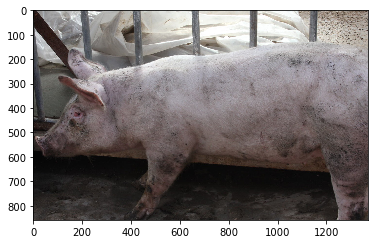

In [26]:
test_img_path = 'test_A/71.JPG'
test_img = imread(test_img_path)
plt.imshow(test_img)

In [27]:
# Run this cell if you don't have a vgg graph built
if 'vgg' in globals():
    print('"vgg" object already exists.  Will not create again.')
else:
    #create vgg
    with tf.Session() as sess:
        input_ = tf.placeholder(tf.float32, [None, 224, 224, 3])
        vgg = vgg16.Vgg16()
        vgg.build(input_)

E:\PROJECT\Code\Sample-tranferlearning-vgg\tensorflow_vgg\vgg16.npy
npy file loaded
build model started
build model finished: 0s


In [28]:
with tf.Session() as sess:
    img = utils.load_image(test_img_path)
    img = img.reshape((1, 224, 224, 3))

    feed_dict = {input_: img}
    code = sess.run(vgg.relu6, feed_dict=feed_dict)
        
saver = tf.train.Saver()
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    
    feed = {inputs_: code}
    prediction = sess.run(predicted, feed_dict=feed).squeeze()

INFO:tensorflow:Restoring parameters from checkpoints\pig.ckpt


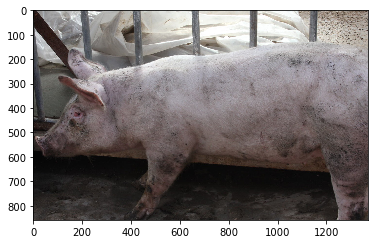

In [29]:
plt.imshow(test_img)

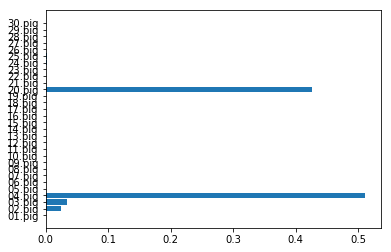

In [30]:
plt.barh(np.arange(30), prediction)
_ = plt.yticks(np.arange(30), lb.classes_)